# 获取数据
比赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值“na”。只有训练数据集包括了每栋房子的价格，也就是标签。

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.3.0


In [2]:
# 读取数据集文件
train_data = pd.read_csv('F:\DataSets/house-prices-advanced/train.csv')
test_data = pd.read_csv('F:\DataSets/house-prices-advanced/test.csv')

In [3]:
# 训练集数据包括1460个样本，80个特征和1个标签
train_data.shape

(1460, 81)

In [4]:
# 测试集数据包括1459个样本，80个特征
test_data.shape

(1459, 80)

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 数据预处理
数据集中有些数据缺失，同时需要对连续数值的特征做标准化：设该特征在整个数据集上的均值为u, 标准差为a， 那么，我们可以将该特征的每个值先减去u再除以a得到标准化后的每个特征值，对于缺失的特征值，我们将其替换成该特征的均值。

In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = \
all_features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())
# 标准化后，每个特征值的均值变为0， 所以可以直接用0来替换缺失值
all_features = all_features.fillna(0)

In [8]:
# dummp_na = True将缺失值也当做合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

In [9]:
# 转换成NDArray格式方便以后训练
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

# 训练模型
使用一个基本的线性回归模型和平方损失函数来训练模型

In [10]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

评估模型使用对数均方根误差

In [11]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1， 使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

训练函数是用来Adam优化算法，相对于之前的小批量随机梯度下降，它对学习率相对不那么敏感

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
         num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用Adam算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate,
                                weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
            
    return train_ls, test_ls

# K折交叉验证

In [13]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
            
    return X_train, y_train, X_valid, y_valid

在K折交叉验证中训练K次并返回训练和验证的平均误差

In [14]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate,
           weight_decay, batch_szie):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                  weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                        range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k    

# 模型选择

fold 0, train rmse 0.240282, valid rmse 0.221796
fold 1, train rmse 0.229682, valid rmse 0.271438
fold 2, train rmse 0.232734, valid rmse 0.238861
fold 3, train rmse 0.238022, valid rmse 0.218900
fold 4, train rmse 0.231282, valid rmse 0.259205
5-fold validation:avg train rmse 0.234400, avg valid rmse 0.242040


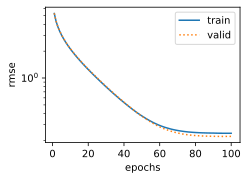

In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_1 = k_fold(k, train_features, train_labels, num_epochs,
                          lr, weight_decay, batch_size)
print('%d-fold validation:avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_1))

# 预测函数

In [16]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                  num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None, 
                       num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

train rmse 0.229512


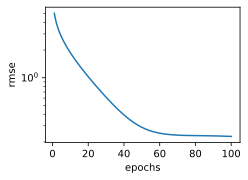

In [17]:
train_and_pred(train_features, test_features, train_labels, test_data, 
              num_epochs, lr, weight_decay, batch_size)